<a href="https://colab.research.google.com/github/Aldrin-Fanir/Hippocampal-Region-Segmentation-UNet/blob/main/HippocampalRegionUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
import copy
import os
import random
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# Drive Mount: Import Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory of Images and Masks

In [3]:
root_path = '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/Cohort1-Multiplexed Dataset'

In [4]:
print("Is path correct?", os.path.exists(root_path))

Is path correct? True


# Hippocampal Region Dataset

In [5]:
class HippocampalDataset(Dataset):
  def __init__(self, root_path, limit = None):
    self.root_path = root_path
    self.limit = limit

    self.images = sorted([root_path + "/cFos_NeuN_dFos_dataset_images/" + i for i in os.listdir(root_path + "/cFos_NeuN_dFos_dataset_images")])[: self.limit]
    self.masks = sorted([root_path + "/cFos_NeuN_dFos_dataset_masks/" + i for i in os.listdir(root_path + "/cFos_NeuN_dFos_dataset_masks")])[: self.limit]

    self.transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    if self.limit is None:
      self.limit = len(self.images)


  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")
    mask = Image.open(self.masks[index]).convert("L")

    return self.transform(img), self.transform(mask)

  def __len__(self):
    return min(len(self.images), self.limit)


# Test Dataset

Batch 1
Image Shape: torch.Size([1, 3, 256, 256])
Mask Shape: torch.Size([1, 1, 256, 256])


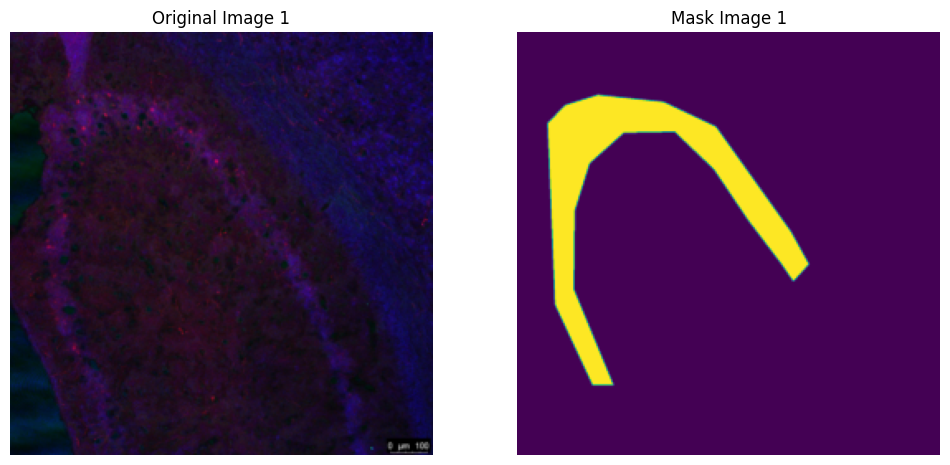

Batch 2
Image Shape: torch.Size([1, 3, 256, 256])
Mask Shape: torch.Size([1, 1, 256, 256])


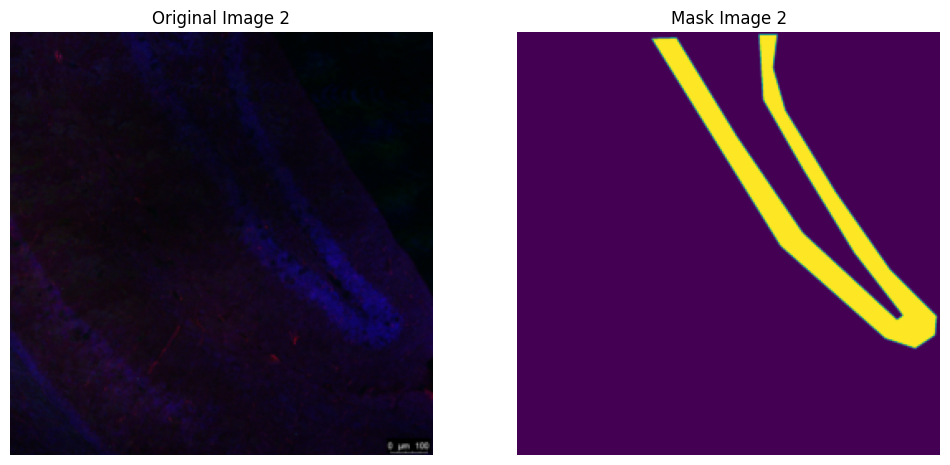

Batch 3
Image Shape: torch.Size([1, 3, 256, 256])
Mask Shape: torch.Size([1, 1, 256, 256])


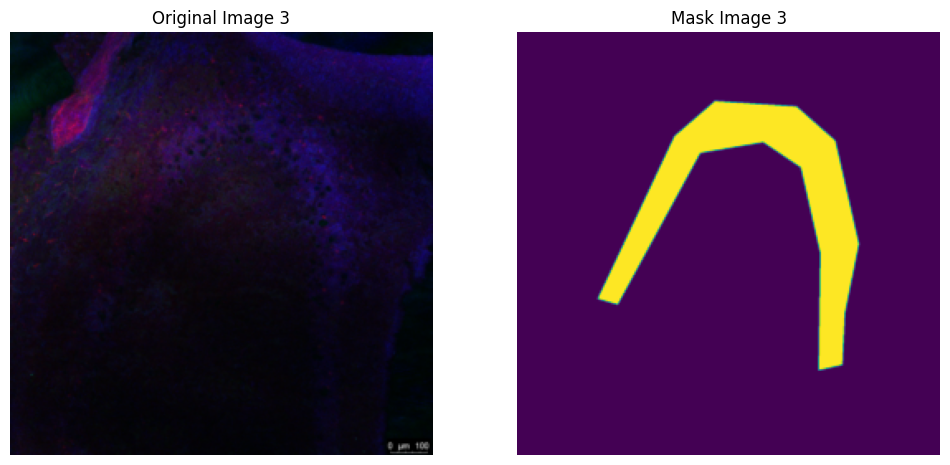

In [6]:
dataset = HippocampalDataset(root_path, limit = 3)

loader = DataLoader(dataset, batch_size = 1, shuffle = True)

for i, (images, masks) in enumerate(loader):
  print(f'Batch {i+1}')
  print(f'Image Shape: {images.shape}')
  print(f'Mask Shape: {masks.shape}')
  plt.figure(figsize=(12, 6))

  #Train Image
  plt.subplot(1, 2, 1)
  plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
  plt.title(f'Original Image {i+1}')
  plt.axis('off')

  #Train Mask
  plt.subplot(1, 2, 2)
  plt.imshow(masks[0].permute(1, 2, 0).cpu().numpy())
  plt.title(f'Mask Image {i+1}')
  plt.axis('off')

  plt.show()

# Create Model

# Double Convolution

In [7]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True)
    )

  def forward(self, x):
    return self.conv_op(x)

# Downsampling

In [8]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

# Upsampling

In [9]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size = 2, stride = 2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)

    return self.conv(x)

# UNet Architecture

In [46]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    #self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(256, 512)

    self.up_convolution_1 = UpSample(512, 256)
    self.up_convolution_2 = UpSample(256, 128)
    self.up_convolution_3 = UpSample(128, 64)
    #self.up_convolution_4 = UpSample(128, 64)

    self.output = nn.Conv2d(64, out_channels = num_classes, kernel_size = 1)



  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    #down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p3)

    up_1 = self.up_convolution_1(b, down_3)
    up_2 = self.up_convolution_2(up_1, down_2)
    up_3 = self.up_convolution_3(up_2, down_1)
    #up_4 = self.up_convolution_4(up_3, down_1)

    return self.output(up_3)

# Trainning The Model

# Early Sopping

In [47]:
class EarlyStopping:
  def __init__(self, patience = 5, delta = 0):
    super().__init__()
    self.patience = patience
    self.delta = delta
    self.best_score = None
    self. early_stop = False
    self.counter = 0
    self.best_model_state = None


  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.best_model_state = model.state_dict()
    elif score<self.best_score + self.delta:
      self.counter += 1
      if self.counter>= self.patience:
        self.early_stop = True
    else:
      self.best_score = score
      self.best_model_state = model.state_dict()
      self.counter = 0


  def load_best_model(self, model):
    model.load_state_dict(self.best_model_state)

In [48]:
train_dataset = HippocampalDataset(root_path)
generator = torch.Generator().manual_seed(42)

In [49]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

In [50]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator = generator)

**Running this experiment with CUDA**

In [51]:
num_workers = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  num_workers = torch.cuda.device_count()*4

**Now We setup out model using the AdamW optimizer and the BCEWithLogitsLoss**

In [52]:
Learning_Rate = 1e-4
batch_size = 16

train_dataloader = DataLoader(dataset = train_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = False)

model = UNet(in_channels = 3, num_classes = 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr = Learning_Rate)
criterion = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience = 15, delta = 0.001)

In [53]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

239
30
29


**Evaluating Segmentation Performance with DICEMetric**

In [54]:
def dice_coefficient(prediction, target, epsilon = 1e-7):
  prediction_copy = prediction.clone()

  prediction_copy[prediction_copy<0] = 0
  prediction_copy[prediction_copy>0] = 1

  intersection = abs(torch.sum(prediction_copy * target))
  union = torch.sum(prediction_copy) + torch.sum(target)
  dice = (2.0 * intersection + epsilon) / (union + epsilon)

  return dice

In [55]:
torch.cuda.empty_cache()

# Training

In [56]:
epochs = 301
train_losses = []
train_dcs = []

val_losses = []
val_dcs = []

for epoch in tqdm(range(epochs)):
  model.train()
  train_running_loss = 0
  traing_running_dc = 0

  for idx, img_mask in enumerate(tqdm(train_dataloader, position = 0, leave=True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = model(img)
    optimizer.zero_grad()

    dc = dice_coefficient(y_pred, mask)
    loss = criterion(y_pred, mask)

    train_running_loss += loss.item()
    traing_running_dc += dc.item()

    loss.backward()
    optimizer.step()

  train_loss = train_running_loss/(idx + 1)
  train_dc = traing_running_dc/(idx + 1)

  train_losses.append(train_loss)
  train_dcs.append(train_dc)




  model.eval()
  val_running_loss = 0
  val_running_dc = 0

  with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave = True)):
      img = img_mask[0].float().to(device)
      mask = img_mask[1].float().to(device)

      y_pred = model(img)
      loss = criterion(y_pred , mask)
      dc = dice_coefficient(y_pred, mask)

      val_running_loss += loss.item()
      val_running_dc += dc.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

  val_losses.append(val_loss)
  val_dcs.append(val_dc)



  print("-" * 30)
  print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
  print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
  print("\n")
  print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
  print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
  print("-" * 30)


  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Early Stopping")
    break

early_stopping.load_best_model(model)

  0%|          | 1/301 [00:05<25:20,  5.07s/it]

------------------------------
Training Loss EPOCH 1: 0.7098
Training DICE EPOCH 1: 0.1350


Validation Loss EPOCH 1: 0.6755
Validation DICE EPOCH 1: 0.0009
------------------------------


  1%|          | 2/301 [00:10<25:06,  5.04s/it]

------------------------------
Training Loss EPOCH 2: 0.5202
Training DICE EPOCH 2: 0.0001


Validation Loss EPOCH 2: 0.3908
Validation DICE EPOCH 2: 0.0000
------------------------------


  1%|          | 3/301 [00:14<24:37,  4.96s/it]

------------------------------
Training Loss EPOCH 3: 0.3651
Training DICE EPOCH 3: 0.0000


Validation Loss EPOCH 3: 0.3304
Validation DICE EPOCH 3: 0.0000
------------------------------


  1%|▏         | 4/301 [00:20<24:44,  5.00s/it]

------------------------------
Training Loss EPOCH 4: 0.3111
Training DICE EPOCH 4: 0.0000


Validation Loss EPOCH 4: 0.2738
Validation DICE EPOCH 4: 0.0000
------------------------------


  2%|▏         | 5/301 [00:24<24:28,  4.96s/it]

------------------------------
Training Loss EPOCH 5: 0.2662
Training DICE EPOCH 5: 0.0000


Validation Loss EPOCH 5: 0.2387
Validation DICE EPOCH 5: 0.0000
------------------------------


  2%|▏         | 6/301 [00:29<24:26,  4.97s/it]

------------------------------
Training Loss EPOCH 6: 0.2383
Training DICE EPOCH 6: 0.0000


Validation Loss EPOCH 6: 0.2218
Validation DICE EPOCH 6: 0.0000
------------------------------


  2%|▏         | 7/301 [00:34<24:19,  4.97s/it]

------------------------------
Training Loss EPOCH 7: 0.2209
Training DICE EPOCH 7: 0.1605


Validation Loss EPOCH 7: 0.1986
Validation DICE EPOCH 7: 0.4398
------------------------------


  3%|▎         | 8/301 [00:39<24:10,  4.95s/it]

------------------------------
Training Loss EPOCH 8: 0.2002
Training DICE EPOCH 8: 0.4699


Validation Loss EPOCH 8: 0.2095
Validation DICE EPOCH 8: 0.5676
------------------------------


  3%|▎         | 9/301 [00:44<24:17,  4.99s/it]

------------------------------
Training Loss EPOCH 9: 0.2033
Training DICE EPOCH 9: 0.5221


Validation Loss EPOCH 9: 0.1881
Validation DICE EPOCH 9: 0.5716
------------------------------


  3%|▎         | 10/301 [00:49<24:03,  4.96s/it]

------------------------------
Training Loss EPOCH 10: 0.1850
Training DICE EPOCH 10: 0.5585


Validation Loss EPOCH 10: 0.1662
Validation DICE EPOCH 10: 0.6437
------------------------------


  4%|▎         | 11/301 [00:54<24:05,  4.98s/it]

------------------------------
Training Loss EPOCH 11: 0.1790
Training DICE EPOCH 11: 0.5899


Validation Loss EPOCH 11: 0.1635
Validation DICE EPOCH 11: 0.6344
------------------------------


  4%|▍         | 12/301 [00:59<24:01,  4.99s/it]

------------------------------
Training Loss EPOCH 12: 0.1753
Training DICE EPOCH 12: 0.6017


Validation Loss EPOCH 12: 0.1646
Validation DICE EPOCH 12: 0.6495
------------------------------


  4%|▍         | 13/301 [01:04<23:49,  4.96s/it]

------------------------------
Training Loss EPOCH 13: 0.1726
Training DICE EPOCH 13: 0.6018


Validation Loss EPOCH 13: 0.1615
Validation DICE EPOCH 13: 0.6460
------------------------------


  5%|▍         | 14/301 [01:09<23:54,  5.00s/it]

------------------------------
Training Loss EPOCH 14: 0.1734
Training DICE EPOCH 14: 0.5834


Validation Loss EPOCH 14: 0.1581
Validation DICE EPOCH 14: 0.6578
------------------------------


  5%|▍         | 15/301 [01:14<23:46,  4.99s/it]

------------------------------
Training Loss EPOCH 15: 0.1694
Training DICE EPOCH 15: 0.5957


Validation Loss EPOCH 15: 0.1597
Validation DICE EPOCH 15: 0.6576
------------------------------


  5%|▌         | 16/301 [01:19<23:47,  5.01s/it]

------------------------------
Training Loss EPOCH 16: 0.1684
Training DICE EPOCH 16: 0.6133


Validation Loss EPOCH 16: 0.1531
Validation DICE EPOCH 16: 0.6523
------------------------------


  6%|▌         | 17/301 [01:24<23:31,  4.97s/it]

------------------------------
Training Loss EPOCH 17: 0.1680
Training DICE EPOCH 17: 0.6145


Validation Loss EPOCH 17: 0.1618
Validation DICE EPOCH 17: 0.6388
------------------------------


  6%|▌         | 18/301 [01:29<23:33,  5.00s/it]

------------------------------
Training Loss EPOCH 18: 0.1678
Training DICE EPOCH 18: 0.5801


Validation Loss EPOCH 18: 0.1546
Validation DICE EPOCH 18: 0.6621
------------------------------


  6%|▋         | 19/301 [01:34<23:21,  4.97s/it]

------------------------------
Training Loss EPOCH 19: 0.1646
Training DICE EPOCH 19: 0.6177


Validation Loss EPOCH 19: 0.1546
Validation DICE EPOCH 19: 0.6173
------------------------------


  7%|▋         | 20/301 [01:39<23:21,  4.99s/it]

------------------------------
Training Loss EPOCH 20: 0.1658
Training DICE EPOCH 20: 0.6009


Validation Loss EPOCH 20: 0.1633
Validation DICE EPOCH 20: 0.6461
------------------------------


  7%|▋         | 21/301 [01:44<23:21,  5.01s/it]

------------------------------
Training Loss EPOCH 21: 0.1649
Training DICE EPOCH 21: 0.6080


Validation Loss EPOCH 21: 0.1511
Validation DICE EPOCH 21: 0.6612
------------------------------


  7%|▋         | 22/301 [01:49<23:04,  4.96s/it]

------------------------------
Training Loss EPOCH 22: 0.1636
Training DICE EPOCH 22: 0.6159


Validation Loss EPOCH 22: 0.1484
Validation DICE EPOCH 22: 0.6596
------------------------------


  8%|▊         | 23/301 [01:54<23:00,  4.97s/it]

------------------------------
Training Loss EPOCH 23: 0.1626
Training DICE EPOCH 23: 0.6060


Validation Loss EPOCH 23: 0.1576
Validation DICE EPOCH 23: 0.6364
------------------------------


  8%|▊         | 24/301 [01:59<22:56,  4.97s/it]

------------------------------
Training Loss EPOCH 24: 0.1601
Training DICE EPOCH 24: 0.6217


Validation Loss EPOCH 24: 0.1555
Validation DICE EPOCH 24: 0.6672
------------------------------


  8%|▊         | 25/301 [02:04<22:55,  4.98s/it]

------------------------------
Training Loss EPOCH 25: 0.1601
Training DICE EPOCH 25: 0.6243


Validation Loss EPOCH 25: 0.1492
Validation DICE EPOCH 25: 0.6786
------------------------------


  9%|▊         | 26/301 [02:09<22:53,  4.99s/it]

------------------------------
Training Loss EPOCH 26: 0.1640
Training DICE EPOCH 26: 0.6125


Validation Loss EPOCH 26: 0.1458
Validation DICE EPOCH 26: 0.6501
------------------------------


  9%|▉         | 27/301 [02:14<22:40,  4.96s/it]

------------------------------
Training Loss EPOCH 27: 0.1601
Training DICE EPOCH 27: 0.6232


Validation Loss EPOCH 27: 0.1490
Validation DICE EPOCH 27: 0.6215
------------------------------


  9%|▉         | 28/301 [02:19<22:41,  4.99s/it]

------------------------------
Training Loss EPOCH 28: 0.1566
Training DICE EPOCH 28: 0.6300


Validation Loss EPOCH 28: 0.1511
Validation DICE EPOCH 28: 0.6695
------------------------------


 10%|▉         | 29/301 [02:24<22:28,  4.96s/it]

------------------------------
Training Loss EPOCH 29: 0.1553
Training DICE EPOCH 29: 0.6213


Validation Loss EPOCH 29: 0.1415
Validation DICE EPOCH 29: 0.6792
------------------------------


 10%|▉         | 30/301 [02:29<22:20,  4.95s/it]

------------------------------
Training Loss EPOCH 30: 0.1634
Training DICE EPOCH 30: 0.6169


Validation Loss EPOCH 30: 0.1554
Validation DICE EPOCH 30: 0.6677
------------------------------


 10%|█         | 31/301 [02:34<22:15,  4.95s/it]

------------------------------
Training Loss EPOCH 31: 0.1598
Training DICE EPOCH 31: 0.6038


Validation Loss EPOCH 31: 0.1446
Validation DICE EPOCH 31: 0.6464
------------------------------


 11%|█         | 32/301 [02:39<22:08,  4.94s/it]

------------------------------
Training Loss EPOCH 32: 0.1616
Training DICE EPOCH 32: 0.6137


Validation Loss EPOCH 32: 0.1623
Validation DICE EPOCH 32: 0.5982
------------------------------


 11%|█         | 33/301 [02:44<22:12,  4.97s/it]

------------------------------
Training Loss EPOCH 33: 0.1632
Training DICE EPOCH 33: 0.6013


Validation Loss EPOCH 33: 0.1491
Validation DICE EPOCH 33: 0.6609
------------------------------


 11%|█▏        | 34/301 [02:49<22:01,  4.95s/it]

------------------------------
Training Loss EPOCH 34: 0.1526
Training DICE EPOCH 34: 0.6283


Validation Loss EPOCH 34: 0.1421
Validation DICE EPOCH 34: 0.6683
------------------------------


 12%|█▏        | 35/301 [02:54<21:58,  4.96s/it]

------------------------------
Training Loss EPOCH 35: 0.1505
Training DICE EPOCH 35: 0.6571


Validation Loss EPOCH 35: 0.1455
Validation DICE EPOCH 35: 0.6753
------------------------------


 12%|█▏        | 36/301 [02:59<21:57,  4.97s/it]

------------------------------
Training Loss EPOCH 36: 0.1575
Training DICE EPOCH 36: 0.6272


Validation Loss EPOCH 36: 0.1482
Validation DICE EPOCH 36: 0.6282
------------------------------


 12%|█▏        | 37/301 [03:04<21:48,  4.95s/it]

------------------------------
Training Loss EPOCH 37: 0.1525
Training DICE EPOCH 37: 0.6352


Validation Loss EPOCH 37: 0.1389
Validation DICE EPOCH 37: 0.6813
------------------------------


 13%|█▎        | 38/301 [03:09<22:04,  5.04s/it]

------------------------------
Training Loss EPOCH 38: 0.1467
Training DICE EPOCH 38: 0.6618


Validation Loss EPOCH 38: 0.1368
Validation DICE EPOCH 38: 0.6878
------------------------------


 13%|█▎        | 39/301 [03:14<21:48,  4.99s/it]

------------------------------
Training Loss EPOCH 39: 0.1464
Training DICE EPOCH 39: 0.6646


Validation Loss EPOCH 39: 0.1345
Validation DICE EPOCH 39: 0.6841
------------------------------


 13%|█▎        | 40/301 [03:19<21:41,  4.99s/it]

------------------------------
Training Loss EPOCH 40: 0.1430
Training DICE EPOCH 40: 0.6698


Validation Loss EPOCH 40: 0.1341
Validation DICE EPOCH 40: 0.6897
------------------------------


 14%|█▎        | 41/301 [03:23<21:26,  4.95s/it]

------------------------------
Training Loss EPOCH 41: 0.1389
Training DICE EPOCH 41: 0.6834


Validation Loss EPOCH 41: 0.1342
Validation DICE EPOCH 41: 0.6994
------------------------------


 14%|█▍        | 42/301 [03:28<21:16,  4.93s/it]

------------------------------
Training Loss EPOCH 42: 0.1394
Training DICE EPOCH 42: 0.6802


Validation Loss EPOCH 42: 0.1439
Validation DICE EPOCH 42: 0.7027
------------------------------


 14%|█▍        | 43/301 [03:34<21:31,  5.01s/it]

------------------------------
Training Loss EPOCH 43: 0.1431
Training DICE EPOCH 43: 0.6774


Validation Loss EPOCH 43: 0.1314
Validation DICE EPOCH 43: 0.6771
------------------------------


 15%|█▍        | 44/301 [03:39<21:25,  5.00s/it]

------------------------------
Training Loss EPOCH 44: 0.1413
Training DICE EPOCH 44: 0.6757


Validation Loss EPOCH 44: 0.1390
Validation DICE EPOCH 44: 0.6823
------------------------------


 15%|█▍        | 45/301 [03:43<21:19,  5.00s/it]

------------------------------
Training Loss EPOCH 45: 0.1404
Training DICE EPOCH 45: 0.6761


Validation Loss EPOCH 45: 0.1423
Validation DICE EPOCH 45: 0.6917
------------------------------


 15%|█▌        | 46/301 [03:48<21:04,  4.96s/it]

------------------------------
Training Loss EPOCH 46: 0.1365
Training DICE EPOCH 46: 0.6908


Validation Loss EPOCH 46: 0.1298
Validation DICE EPOCH 46: 0.6952
------------------------------


 16%|█▌        | 47/301 [03:53<20:50,  4.92s/it]

------------------------------
Training Loss EPOCH 47: 0.1358
Training DICE EPOCH 47: 0.6908


Validation Loss EPOCH 47: 0.1363
Validation DICE EPOCH 47: 0.6828
------------------------------


 16%|█▌        | 48/301 [03:58<20:58,  4.97s/it]

------------------------------
Training Loss EPOCH 48: 0.1334
Training DICE EPOCH 48: 0.6903


Validation Loss EPOCH 48: 0.1306
Validation DICE EPOCH 48: 0.7192
------------------------------


 16%|█▋        | 49/301 [04:03<20:48,  4.95s/it]

------------------------------
Training Loss EPOCH 49: 0.1304
Training DICE EPOCH 49: 0.7039


Validation Loss EPOCH 49: 0.1280
Validation DICE EPOCH 49: 0.7203
------------------------------


 17%|█▋        | 50/301 [04:08<20:58,  5.01s/it]

------------------------------
Training Loss EPOCH 50: 0.1315
Training DICE EPOCH 50: 0.7019


Validation Loss EPOCH 50: 0.1239
Validation DICE EPOCH 50: 0.7199
------------------------------


 17%|█▋        | 51/301 [04:13<20:49,  5.00s/it]

------------------------------
Training Loss EPOCH 51: 0.1318
Training DICE EPOCH 51: 0.6998


Validation Loss EPOCH 51: 0.1273
Validation DICE EPOCH 51: 0.7090
------------------------------


 17%|█▋        | 52/301 [04:18<20:45,  5.00s/it]

------------------------------
Training Loss EPOCH 52: 0.1330
Training DICE EPOCH 52: 0.7008


Validation Loss EPOCH 52: 0.1313
Validation DICE EPOCH 52: 0.6661
------------------------------


 18%|█▊        | 53/301 [04:23<20:39,  5.00s/it]

------------------------------
Training Loss EPOCH 53: 0.1263
Training DICE EPOCH 53: 0.7162


Validation Loss EPOCH 53: 0.1245
Validation DICE EPOCH 53: 0.7185
------------------------------


 18%|█▊        | 54/301 [04:28<20:33,  4.99s/it]

------------------------------
Training Loss EPOCH 54: 0.1255
Training DICE EPOCH 54: 0.7137


Validation Loss EPOCH 54: 0.1220
Validation DICE EPOCH 54: 0.7223
------------------------------


 18%|█▊        | 55/301 [04:33<20:35,  5.02s/it]

------------------------------
Training Loss EPOCH 55: 0.1228
Training DICE EPOCH 55: 0.7199


Validation Loss EPOCH 55: 0.1232
Validation DICE EPOCH 55: 0.7380
------------------------------


 19%|█▊        | 56/301 [04:38<20:28,  5.02s/it]

------------------------------
Training Loss EPOCH 56: 0.1223
Training DICE EPOCH 56: 0.7278


Validation Loss EPOCH 56: 0.1240
Validation DICE EPOCH 56: 0.7154
------------------------------


 19%|█▉        | 57/301 [04:43<20:14,  4.98s/it]

------------------------------
Training Loss EPOCH 57: 0.1225
Training DICE EPOCH 57: 0.7265


Validation Loss EPOCH 57: 0.1256
Validation DICE EPOCH 57: 0.7282
------------------------------


 19%|█▉        | 58/301 [04:48<20:11,  4.99s/it]

------------------------------
Training Loss EPOCH 58: 0.1239
Training DICE EPOCH 58: 0.7202


Validation Loss EPOCH 58: 0.1234
Validation DICE EPOCH 58: 0.7293
------------------------------


 20%|█▉        | 59/301 [04:53<20:03,  4.97s/it]

------------------------------
Training Loss EPOCH 59: 0.1211
Training DICE EPOCH 59: 0.7239


Validation Loss EPOCH 59: 0.1196
Validation DICE EPOCH 59: 0.7198
------------------------------


 20%|█▉        | 60/301 [04:58<20:01,  4.99s/it]

------------------------------
Training Loss EPOCH 60: 0.1175
Training DICE EPOCH 60: 0.7346


Validation Loss EPOCH 60: 0.1194
Validation DICE EPOCH 60: 0.7371
------------------------------


 20%|██        | 61/301 [05:03<19:51,  4.96s/it]

------------------------------
Training Loss EPOCH 61: 0.1313
Training DICE EPOCH 61: 0.6992


Validation Loss EPOCH 61: 0.1298
Validation DICE EPOCH 61: 0.7132
------------------------------


 21%|██        | 62/301 [05:08<19:45,  4.96s/it]

------------------------------
Training Loss EPOCH 62: 0.1261
Training DICE EPOCH 62: 0.7121


Validation Loss EPOCH 62: 0.1274
Validation DICE EPOCH 62: 0.6746
------------------------------


 21%|██        | 63/301 [05:13<19:44,  4.98s/it]

------------------------------
Training Loss EPOCH 63: 0.1185
Training DICE EPOCH 63: 0.7363


Validation Loss EPOCH 63: 0.1368
Validation DICE EPOCH 63: 0.7254
------------------------------


 21%|██▏       | 64/301 [05:18<19:34,  4.96s/it]

------------------------------
Training Loss EPOCH 64: 0.1217
Training DICE EPOCH 64: 0.7179


Validation Loss EPOCH 64: 0.1223
Validation DICE EPOCH 64: 0.7386
------------------------------


 22%|██▏       | 65/301 [05:23<19:44,  5.02s/it]

------------------------------
Training Loss EPOCH 65: 0.1142
Training DICE EPOCH 65: 0.7458


Validation Loss EPOCH 65: 0.1173
Validation DICE EPOCH 65: 0.7337
------------------------------


 22%|██▏       | 66/301 [05:28<19:35,  5.00s/it]

------------------------------
Training Loss EPOCH 66: 0.1102
Training DICE EPOCH 66: 0.7521


Validation Loss EPOCH 66: 0.1222
Validation DICE EPOCH 66: 0.7479
------------------------------


 22%|██▏       | 67/301 [05:33<19:33,  5.02s/it]

------------------------------
Training Loss EPOCH 67: 0.1127
Training DICE EPOCH 67: 0.7460


Validation Loss EPOCH 67: 0.1178
Validation DICE EPOCH 67: 0.7475
------------------------------


 23%|██▎       | 68/301 [05:38<19:29,  5.02s/it]

------------------------------
Training Loss EPOCH 68: 0.1106
Training DICE EPOCH 68: 0.7548


Validation Loss EPOCH 68: 0.1157
Validation DICE EPOCH 68: 0.7388
------------------------------


 23%|██▎       | 69/301 [05:43<19:20,  5.00s/it]

------------------------------
Training Loss EPOCH 69: 0.1127
Training DICE EPOCH 69: 0.7461


Validation Loss EPOCH 69: 0.1160
Validation DICE EPOCH 69: 0.7516
------------------------------


 23%|██▎       | 70/301 [05:48<19:26,  5.05s/it]

------------------------------
Training Loss EPOCH 70: 0.1050
Training DICE EPOCH 70: 0.7675


Validation Loss EPOCH 70: 0.1182
Validation DICE EPOCH 70: 0.7483
------------------------------


 24%|██▎       | 71/301 [05:53<19:19,  5.04s/it]

------------------------------
Training Loss EPOCH 71: 0.1060
Training DICE EPOCH 71: 0.7656


Validation Loss EPOCH 71: 0.1193
Validation DICE EPOCH 71: 0.7027
------------------------------


 24%|██▍       | 72/301 [05:58<19:12,  5.03s/it]

------------------------------
Training Loss EPOCH 72: 0.1073
Training DICE EPOCH 72: 0.7595


Validation Loss EPOCH 72: 0.1196
Validation DICE EPOCH 72: 0.7366
------------------------------


 24%|██▍       | 73/301 [06:03<19:01,  5.00s/it]

------------------------------
Training Loss EPOCH 73: 0.1040
Training DICE EPOCH 73: 0.7654


Validation Loss EPOCH 73: 0.1393
Validation DICE EPOCH 73: 0.6624
------------------------------


 25%|██▍       | 74/301 [06:08<18:52,  4.99s/it]

------------------------------
Training Loss EPOCH 74: 0.1126
Training DICE EPOCH 74: 0.7485


Validation Loss EPOCH 74: 0.1156
Validation DICE EPOCH 74: 0.7303
------------------------------


 25%|██▍       | 75/301 [06:13<18:52,  5.01s/it]

------------------------------
Training Loss EPOCH 75: 0.1047
Training DICE EPOCH 75: 0.7661


Validation Loss EPOCH 75: 0.1147
Validation DICE EPOCH 75: 0.7504
------------------------------


 25%|██▌       | 76/301 [06:18<18:41,  4.98s/it]

------------------------------
Training Loss EPOCH 76: 0.0986
Training DICE EPOCH 76: 0.7866


Validation Loss EPOCH 76: 0.1172
Validation DICE EPOCH 76: 0.7447
------------------------------


 26%|██▌       | 77/301 [06:23<18:42,  5.01s/it]

------------------------------
Training Loss EPOCH 77: 0.0985
Training DICE EPOCH 77: 0.7882


Validation Loss EPOCH 77: 0.1174
Validation DICE EPOCH 77: 0.7460
------------------------------


 26%|██▌       | 78/301 [06:28<18:43,  5.04s/it]

------------------------------
Training Loss EPOCH 78: 0.0973
Training DICE EPOCH 78: 0.7871


Validation Loss EPOCH 78: 0.1165
Validation DICE EPOCH 78: 0.7274
------------------------------


 26%|██▌       | 79/301 [06:33<18:28,  4.99s/it]

------------------------------
Training Loss EPOCH 79: 0.0959
Training DICE EPOCH 79: 0.7901


Validation Loss EPOCH 79: 0.1168
Validation DICE EPOCH 79: 0.7557
------------------------------


 27%|██▋       | 80/301 [06:38<18:25,  5.00s/it]

------------------------------
Training Loss EPOCH 80: 0.0957
Training DICE EPOCH 80: 0.7896


Validation Loss EPOCH 80: 0.1205
Validation DICE EPOCH 80: 0.7515
------------------------------


 27%|██▋       | 81/301 [06:43<18:12,  4.97s/it]

------------------------------
Training Loss EPOCH 81: 0.1015
Training DICE EPOCH 81: 0.7759


Validation Loss EPOCH 81: 0.1206
Validation DICE EPOCH 81: 0.7512
------------------------------


 27%|██▋       | 82/301 [06:48<18:12,  4.99s/it]

------------------------------
Training Loss EPOCH 82: 0.1005
Training DICE EPOCH 82: 0.7780


Validation Loss EPOCH 82: 0.1247
Validation DICE EPOCH 82: 0.7522
------------------------------


 27%|██▋       | 82/301 [06:53<18:24,  5.05s/it]

------------------------------
Training Loss EPOCH 83: 0.0987
Training DICE EPOCH 83: 0.7790


Validation Loss EPOCH 83: 0.1432
Validation DICE EPOCH 83: 0.7293
------------------------------
Early Stopping


# Model Save

In [57]:
torch.save(model.state_dict(), '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/HippocampalRegionCohortMultiplexUNet301.pth')

# Results


**Training and Validation**



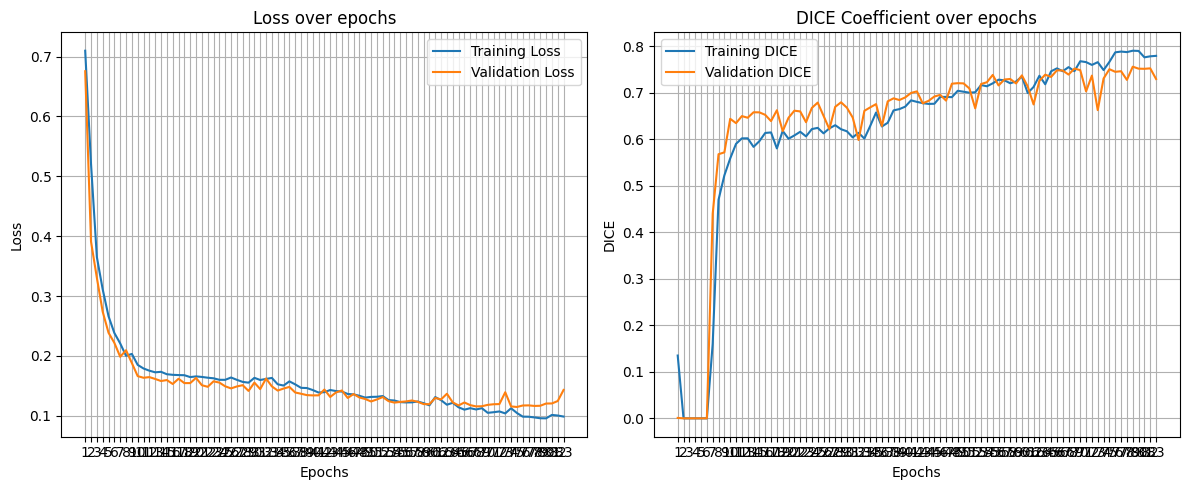

In [58]:
epochs_list = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, len(train_losses)+1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, len(train_losses)+1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.tight_layout()
plt.legend()

plt.show()

# Test

In [60]:
model_path = '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/HippocampalRegionCohortMultiplexUNet301.pth'
trained_model = UNet(in_channels = 3, num_classes = 1).to(device)
trained_model.load_state_dict(torch.load(model_path, map_location = torch.device(device)))

<All keys matched successfully>

In [61]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
  for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave = True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = trained_model(img)
    loss = criterion(y_pred , mask)
    dc = dice_coefficient(y_pred, mask)

    test_running_loss += loss.item()
    test_running_dc += dc.item()

  test_loss = test_running_loss / (idx + 1)
  test_dc = test_running_dc / (idx + 1)

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


In [62]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test DICE: {test_dc:.4f}')

Test Loss: 0.1432
Test DICE: 0.7472


In [63]:
def random_image_inference(image_tensor, mask_tensor, image_paths, model_path, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    for img_tensor, mask_tensor_item, img_path in zip(image_tensor, mask_tensor, image_paths):
        img = img_tensor.to(device)
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1, 2, 0)


        mask = mask_tensor_item.permute(1, 2, 0).to(device)


        dice = dice_coefficient(pred_mask.cpu(), mask.cpu())
        print(f'Image: {os.path.basename(img_path)}, DICE coefficient: {round(float(dice),5)}')

        img_disp = img.cpu().detach().permute(1, 2, 0)
        pred_mask_disp = pred_mask.cpu().detach()
        pred_mask_disp[pred_mask_disp < 0] = 0
        pred_mask_disp[pred_mask_disp > 0] = 1


        plt.figure(figsize=(5,7))
        plt.subplot(131), plt.imshow(img_disp), plt.title("Original Image")
        plt.subplot(132), plt.imshow(pred_mask_disp.squeeze(), cmap='gray'), plt.title("Predicted Mask")
        plt.subplot(133), plt.imshow(mask.cpu().squeeze(), cmap='gray'), plt.title("Mask")
        plt.show()

**Load Some Random Images**

In [64]:
n = 10
image_tensors = []
mask_tensors = []
image_paths = []

original_dataset = HippocampalDataset(root_path)


for i in range(n):
  random_index = random.randint(0, len(test_dataloader.dataset) - 1)

  original_index = test_dataloader.dataset.indices[random_index]
  random_sample = test_dataloader.dataset[random_index]

  image_tensors.append(random_sample[0])
  mask_tensors.append(random_sample[1])

  image_paths.append(original_dataset.images[original_index])

Image: 11dg-12_2.tif, DICE coefficient: 0.70868


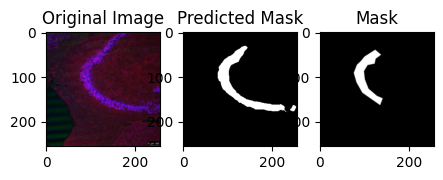

Image: 10dg-11_2.tif, DICE coefficient: 0.80441


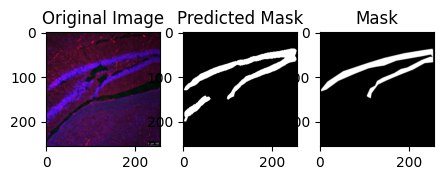

Image: 10ca3-12_2.tif, DICE coefficient: 0.53331


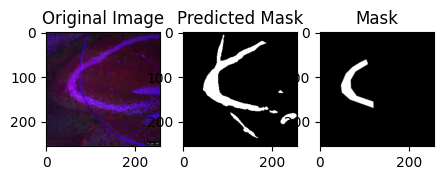

Image: 1.2dg-1_2.tif, DICE coefficient: 0.93233


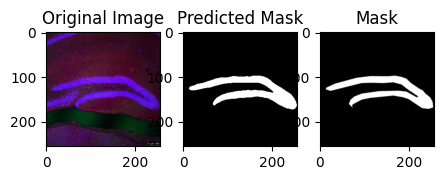

Image: 1.2dg-1_2.tif, DICE coefficient: 0.93233


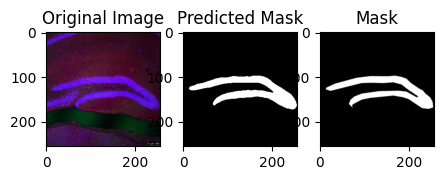

Image: 10.2dg-3_2.tif, DICE coefficient: 0.63707


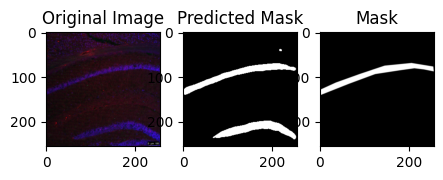

Image: 12ca3-25_2.tif, DICE coefficient: 0.83591


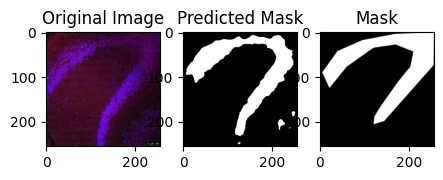

Image: 10ca3-13_2.tif, DICE coefficient: 0.7296


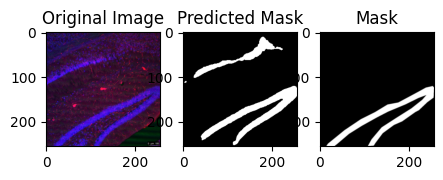

Image: 10.2dg-5_2.tif, DICE coefficient: 0.88759


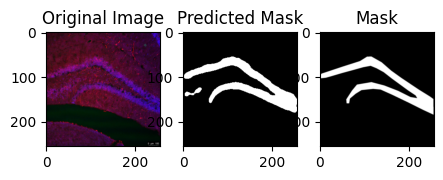

Image: 12ca3-25_2.tif, DICE coefficient: 0.83591


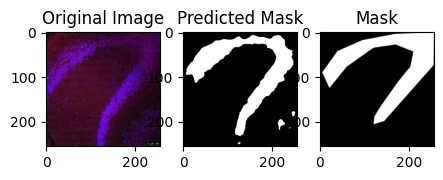

In [65]:
random_image_inference(image_tensors, mask_tensors, image_paths, model_path, device='cpu')